# AIMNet2 tmQM-OpenFF

## Import AIMNet2 tmQM-OpenFF trainings

In [1]:
import glob
import importlib
import os
import sys
import statistics

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import toml
import torch
import wandb

import helper
from helper import extract_config, calculate_reference_energy, test_nnp_with_fixed_tmqm_subset
from modelforge.dataset.dataset import initialize_datamodule
from modelforge.dataset.utils import RandomRecordSplittingStrategy, SplittingStrategy
from modelforge.potential.potential import load_inference_model_from_checkpoint

sns.set_theme()
sns.set_context("notebook")
# Set the option to display all columns
pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
api = wandb.Api()
runs = api.runs(
    "modelforge_nnps/aimnet2_tmqm_openff",
    # filters={"group": "exp08_3"},
)
print(f"Found {len(runs)} runs")
summary_list, config_list, name_list = [], [], []

Found 257 runs


In [3]:
extract_config(runs[0].config["training_parameter"], "tags")

{'tags': ['seed=42',
  'full_dataset_sm3_v1.1',
  'per_system_energy=0.0001',
  'per_system_dipole_moment=0',
  'per_atom_charge=1',
  '0.1.4+300.gef9c8be.dirty',
  'tmqm_openff_local',
  'AimNet2',
  'loss-per_system_energy',
  'loss-per_system_dipole_moment',
  'loss-per_atom_charge']}

In [4]:
runs[0].summary["val/per_system_energy/mae"]

65.10548400878906

In [5]:
exp_results = []

for run in runs:
    if run.state == "finished":
        record = {}
    
        record.update({"name": run.name})
        
        training_parameter = run.config["training_parameter"]
        potential_parameter = run.config['potential_parameter']
        tags = extract_config(training_parameter, "tags")["tags"]

        try:
            record.update({
                "test/per_system_energy/mae": run.summary["test/per_system_energy/mae"],
                "test/per_system_energy/rmse": run.summary["test/per_system_energy/rmse"],
            })
        except KeyError:
            record.update({
                "test/per_system_energy/mae": pd.NA,
                "test/per_system_energy/rmse": pd.NA,
            })

        record.update({
                "test/per_atom_charge/mae": pd.NA,
                "test/per_atom_charge/rmse": pd.NA,
            })
        record.update({
                "test/per_system_dipole_moment/mae": pd.NA,
                "test/per_system_dipole_moment/rmse": pd.NA,
            })
        
        record.update({
                "val/per_system_energy/mae": run.summary["val/per_system_energy/mae"],
                "val/per_system_energy/rmse": run.summary["val/per_system_energy/rmse"],
                "val/per_system_dipole_moment/mae": run.summary["val/per_system_dipole_moment/mae"],
                "val/per_atom_charge/mae": run.summary["val/per_atom_charge/mae"],
            })
        
        record.update(extract_config(potential_parameter, "number_of_radial_basis_functions"))
        record.update(extract_config(potential_parameter, "number_of_vector_features"))
        record.update(extract_config(potential_parameter, "number_of_per_atom_features"))

        loss_weights = extract_config(training_parameter, "weight")
        record.update(loss_weights["weight"])

        record["dataset_version"] = extract_config(run.config["training_parameter"], "tags")["tags"][1]
        if "spin_multiplicity_embedding" in tags:
            record["spin_embedding"] = True
        else:
            record["spin_embedding"] = False

        record["group"] = run.group
        record.update(
            extract_config(training_parameter, "seed")
        )
        exp_results.append(record)

exp_results_df = pd.DataFrame(exp_results)

### Load results from fixed tests

In [6]:
exp = "exp08_3"
dataset_filename = f"../experiments/{exp}/cache/fixed_test_subset/fixed_test_subset_v1.2.hdf5"
exp_results = glob.glob(f"../experiments/{exp}/run_*/*/test_results/*")

for i in exp_results:
    try:
        error = pd.read_csv(os.path.join(i, "mae.txt"), sep='\t')
        exp_results_df.loc[exp_results_df["name"] == error.iloc[0]["name"], "test/per_system_energy/mae"] = error.iloc[0]["test/per_system_energy/mae"]
        exp_results_df.loc[exp_results_df["name"] == error.iloc[0]["name"], "test/per_system_energy/rmse"] = error.iloc[0]["test/per_system_energy/rmse"]
        exp_results_df.loc[exp_results_df["name"] == error.iloc[0]["name"], "test/per_atom_charge/mae"] = error.iloc[0]["test/per_atom_charge/mae"]
        # exp_results_df.loc[exp_results_df["name"] == error.iloc[0]["name"], "test/per_atom_charge/rmse"] = error.iloc[0]["test/per_atom_charge/rmse"]
        exp_results_df.loc[exp_results_df["name"] == error.iloc[0]["name"], "test/per_system_dipole_moment/mae"] = error.iloc[0]["test/per_system_dipole_moment/mae"]
        # exp_results_df.loc[exp_results_df["name"] == error.iloc[0]["name"], "test/per_system_dipole_moment/rmse"] = error.iloc[0]["test/per_system_dipole_moment/rmse"]
    except Exception as e:
        pass

In [7]:
exp_results_df.sort_values(by="test/per_system_energy/mae").head(50)

,name,test/per_system_energy/mae,test/per_system_energy/rmse,test/per_atom_charge/mae,test/per_atom_charge/rmse,test/per_system_dipole_moment/mae,test/per_system_dipole_moment/rmse,val/per_system_energy/mae,val/per_system_energy/rmse,val/per_system_dipole_moment/mae,val/per_atom_charge/mae,number_of_radial_basis_functions,number_of_vector_features,number_of_per_atom_features,per_system_energy,per_system_dipole_moment,per_atom_charge,dataset_version,spin_embedding,group,seed
221,"full_dataset_v1.2_[0.0001, 0, 1]_(45)",51.070604,86.14447,0.035162,<NA>,0.144881,<NA>,47.071945,86.559341,0.147555,0.035212,64,8,128,0.0001,0.0,1.0,full_dataset_v1.2,True,exp08_3,45
163,"sm_1_n_configs_10_v1.2_[0.0001, 0.1, 0]_(42)",54.097587,90.956055,0.227731,<NA>,0.1432,<NA>,50.832760,91.653175,0.149640,0.226110,64,8,128,0.0001,0.1,0.0,sm_1_n_configs_10_v1.2,True,exp08_3,42
222,"sm_1_n_configs_10_v1.2_[0.0001, 0, 1]_(46)",55.447642,91.129888,0.030703,<NA>,0.149938,<NA>,56.078342,99.705139,0.156309,0.033192,64,8,128,0.0001,0.0,1.0,sm_1_n_configs_10_v1.2,True,exp08_3,46
203,"full_dataset_v1.2_[0.0001, 0.1, 0]_(44)",55.584137,96.890449,0.188244,<NA>,0.13767,<NA>,48.061447,86.444557,0.140324,0.189907,64,8,128,0.0001,0.1,0.0,full_dataset_v1.2,True,exp08_3,44
161,"sm_3_n_configs_10_v1.2_[0.0001, 0.1, 1]_(42)",55.678562,90.656046,0.029346,<NA>,0.132883,<NA>,52.086086,93.028130,0.135807,0.030554,64,8,128,0.0001,0.1,1.0,sm_3_n_configs_10_v1.2,True,exp08_3,42
236,"full_dataset_v1.2_[1, 0, 0]_(46)",56.52673,91.713751,0.200199,<NA>,0.172936,<NA>,57.341881,94.107986,0.169494,0.201217,64,8,128,1.0000,0.0,0.0,full_dataset_v1.2,True,exp08_3,46
205,"full_dataset_v1.2_[1, 0, 0]_(44)",56.749176,90.445752,0.156954,<NA>,0.213929,<NA>,56.105370,92.152718,0.219963,0.156227,64,8,128,1.0000,0.0,0.0,full_dataset_v1.2,True,exp08_3,44
234,"full_dataset_v1.2_[0.0001, 0, 1]_(46)",56.867731,102.838047,0.023105,<NA>,0.138562,<NA>,46.471733,85.297318,0.136738,0.024444,64,8,128,0.0001,0.0,1.0,full_dataset_v1.2,True,exp08_3,46
225,"sm_1_n_configs_10_v1.2_[1, 0, 0]_(46)",57.381264,91.366461,0.213551,<NA>,0.170386,<NA>,57.968212,97.428780,0.175319,0.214314,64,8,128,1.0000,0.0,0.0,sm_1_n_configs_10_v1.2,True,exp08_3,46
191,"sm_1_n_configs_10_v1.2_[0.0001, 0.1, 0]_(44)",57.656118,93.586456,0.126716,<NA>,0.149779,<NA>,53.612797,90.806915,0.163044,0.127200,64,8,128,0.0001,0.1,0.0,sm_1_n_configs_10_v1.2,True,exp08_3,44


In [8]:
exp_results_df.sort_values(by="val/per_atom_charge/mae").head(20)

,name,test/per_system_energy/mae,test/per_system_energy/rmse,test/per_atom_charge/mae,test/per_atom_charge/rmse,test/per_system_dipole_moment/mae,test/per_system_dipole_moment/rmse,val/per_system_energy/mae,val/per_system_energy/rmse,val/per_system_dipole_moment/mae,val/per_atom_charge/mae,number_of_radial_basis_functions,number_of_vector_features,number_of_per_atom_features,per_system_energy,per_system_dipole_moment,per_atom_charge,dataset_version,spin_embedding,group,seed
234,"full_dataset_v1.2_[0.0001, 0, 1]_(46)",56.867731,102.838047,0.023105,<NA>,0.138562,<NA>,46.471733,85.297318,0.136738,0.024444,64,8,128,0.0001,0.0,1.0,full_dataset_v1.2,True,exp08_3,46
171,"full_dataset_v1.2_[0.0001, 0.1, 1]_(42)",59.061138,96.017499,0.025857,<NA>,0.132771,<NA>,60.566940,104.851944,0.131873,0.026340,64,8,128,0.0001,0.1,1.0,full_dataset_v1.2,True,exp08_3,42
172,"sm_1_n_configs_10_v1.2_[0.0001, 0.1, 1]_(43)",58.236719,94.793514,0.025666,<NA>,0.133376,<NA>,53.994968,89.004837,0.134275,0.026568,64,8,128,0.0001,0.1,1.0,sm_1_n_configs_10_v1.2,True,exp08_3,43
202,"full_dataset_v1.2_[0.0001, 0.1, 1]_(44)",62.035353,97.013254,0.027308,<NA>,0.132325,<NA>,63.116585,99.928101,0.137277,0.027865,64,8,128,0.0001,0.1,1.0,full_dataset_v1.2,True,exp08_3,44
67,"full_dataset_sm3_v1.1_[0.0001, 0.1, 1]_(46)",67.393738,106.215736,<NA>,<NA>,<NA>,<NA>,63.612854,99.284760,0.140783,0.028375,64,8,128,0.0001,0.1,1.0,full_dataset_sm3_v1.1,False,full_dataset_sm3_v1.1,46
160,"sm_1_n_configs_10_v1.2_[0.0001, 0, 1]_(42)",59.227311,103.143601,0.026643,<NA>,0.141708,<NA>,47.190578,83.477081,0.149201,0.028612,64,8,128,0.0001,0.0,1.0,sm_1_n_configs_10_v1.2,True,exp08_3,42
217,"full_dataset_v1.2_[0.0001, 0.1, 1]_(45)",60.588186,94.943479,0.028383,<NA>,0.134186,<NA>,61.303745,103.474319,0.134760,0.028797,64,8,128,0.0001,0.1,1.0,full_dataset_v1.2,True,exp08_3,45
201,"full_dataset_v1.2_[0.0001, 0, 1]_(44)",61.747408,94.138082,0.028496,<NA>,0.144816,<NA>,63.711807,99.518059,0.149377,0.029265,64,8,128,0.0001,0.0,1.0,full_dataset_v1.2,True,exp08_3,44
19,"full_dataset_sm3_v1.1_[0.0001, 0.1, 1]_(43)",69.272621,109.931496,<NA>,<NA>,<NA>,<NA>,67.726807,109.161110,0.144102,0.029313,64,8,128,0.0001,0.1,1.0,full_dataset_sm3_v1.1,False,full_dataset_sm3_v1.1,43
233,"full_dataset_v1.2_[0.0001, 0.1, 1]_(46)",61.386668,96.236232,0.028479,<NA>,0.134401,<NA>,60.663425,99.119110,0.132628,0.029480,64,8,128,0.0001,0.1,1.0,full_dataset_v1.2,True,exp08_3,46


In [9]:
exp_results_df.sort_values(by="test/per_system_dipole_moment/mae").head(20)

,name,test/per_system_energy/mae,test/per_system_energy/rmse,test/per_atom_charge/mae,test/per_atom_charge/rmse,test/per_system_dipole_moment/mae,test/per_system_dipole_moment/rmse,val/per_system_energy/mae,val/per_system_energy/rmse,val/per_system_dipole_moment/mae,val/per_atom_charge/mae,number_of_radial_basis_functions,number_of_vector_features,number_of_per_atom_features,per_system_energy,per_system_dipole_moment,per_atom_charge,dataset_version,spin_embedding,group,seed
202,"full_dataset_v1.2_[0.0001, 0.1, 1]_(44)",62.035353,97.013254,0.027308,<NA>,0.132325,<NA>,63.116585,99.928101,0.137277,0.027865,64,8,128,0.0001,0.1,1.0,full_dataset_v1.2,True,exp08_3,44
171,"full_dataset_v1.2_[0.0001, 0.1, 1]_(42)",59.061138,96.017499,0.025857,<NA>,0.132771,<NA>,60.566940,104.851944,0.131873,0.026340,64,8,128,0.0001,0.1,1.0,full_dataset_v1.2,True,exp08_3,42
161,"sm_3_n_configs_10_v1.2_[0.0001, 0.1, 1]_(42)",55.678562,90.656046,0.029346,<NA>,0.132883,<NA>,52.086086,93.028130,0.135807,0.030554,64,8,128,0.0001,0.1,1.0,sm_3_n_configs_10_v1.2,True,exp08_3,42
185,"full_dataset_v1.2_[0.0001, 0.1, 1]_(43)",61.44622,97.280094,0.02638,<NA>,0.133274,<NA>,67.492081,110.152657,0.137710,0.032168,64,8,128,0.0001,0.1,1.0,full_dataset_v1.2,True,exp08_3,43
172,"sm_1_n_configs_10_v1.2_[0.0001, 0.1, 1]_(43)",58.236719,94.793514,0.025666,<NA>,0.133376,<NA>,53.994968,89.004837,0.134275,0.026568,64,8,128,0.0001,0.1,1.0,sm_1_n_configs_10_v1.2,True,exp08_3,43
196,"sm_5_n_configs_10_v1.2_[0.0001, 0.1, 1]_(44)",64.852352,102.26536,0.027343,<NA>,0.133682,<NA>,60.327606,95.480843,0.133145,0.029694,64,8,128,0.0001,0.1,1.0,sm_5_n_configs_10_v1.2,True,exp08_3,44
209,"sm_3_n_configs_10_v1.2_[0.0001, 0.1, 1]_(45)",60.546611,100.589638,0.029544,<NA>,0.133844,<NA>,60.505863,101.336868,0.143832,0.031522,64,8,128,0.0001,0.1,1.0,sm_3_n_configs_10_v1.2,True,exp08_3,45
217,"full_dataset_v1.2_[0.0001, 0.1, 1]_(45)",60.588186,94.943479,0.028383,<NA>,0.134186,<NA>,61.303745,103.474319,0.134760,0.028797,64,8,128,0.0001,0.1,1.0,full_dataset_v1.2,True,exp08_3,45
233,"full_dataset_v1.2_[0.0001, 0.1, 1]_(46)",61.386668,96.236232,0.028479,<NA>,0.134401,<NA>,60.663425,99.119110,0.132628,0.029480,64,8,128,0.0001,0.1,1.0,full_dataset_v1.2,True,exp08_3,46
220,"sm_1_n_configs_10_v1.2_[0.0001, 0.1, 1]_(46)",59.724718,93.793538,0.029215,<NA>,0.134493,<NA>,63.331802,105.751198,0.139245,0.030823,64,8,128,0.0001,0.1,1.0,sm_1_n_configs_10_v1.2,True,exp08_3,46


## Plotting training results

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_context("notebook")

### Dataset splitting consistency

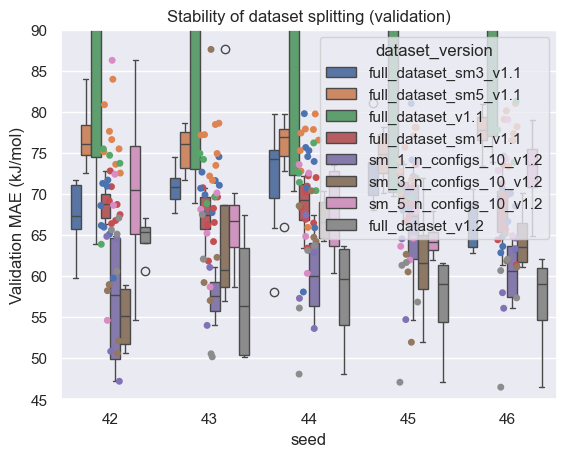

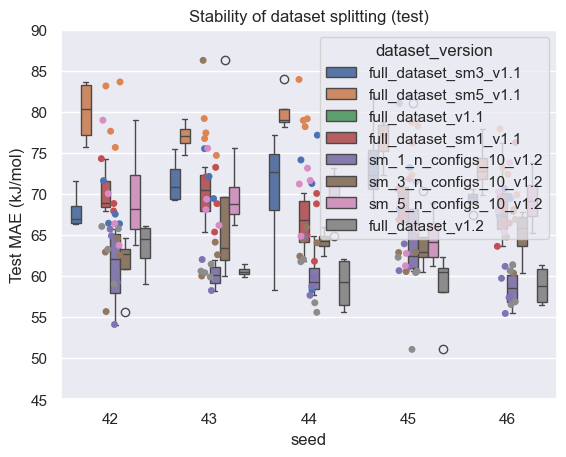

In [11]:
ax = sns.boxplot(
    data=exp_results_df,
    x="seed",
    y="val/per_system_energy/mae",
    hue="dataset_version",
)
sns.stripplot(
    data=exp_results_df, 
    x="seed", 
    y="val/per_system_energy/mae", 
    hue="dataset_version",
    legend=False,
)
ax.set_ylabel("Validation MAE (kJ/mol)")
ax.set_title("Stability of dataset splitting (validation)")
ax.set_ylim(45, 90)
plt.show()



ax = sns.boxplot(
    data=exp_results_df,
    x="seed",
    y="test/per_system_energy/mae",
    hue="dataset_version",
)
sns.stripplot(
    data=exp_results_df, 
    x="seed", 
    y="test/per_system_energy/mae", 
    hue="dataset_version",
    legend=False,
)
ax.set_ylabel("Test MAE (kJ/mol)")
ax.set_title("Stability of dataset splitting (test)")
ax.set_ylim(45, 90)
plt.show()

### Limit to a single spin multiplicity

In [34]:
results_single_spin = exp_results_df[(exp_results_df["dataset_version"] != "full_dataset_v1.2") & (exp_results_df["dataset_version"] != "full_dataset_v1.1")]

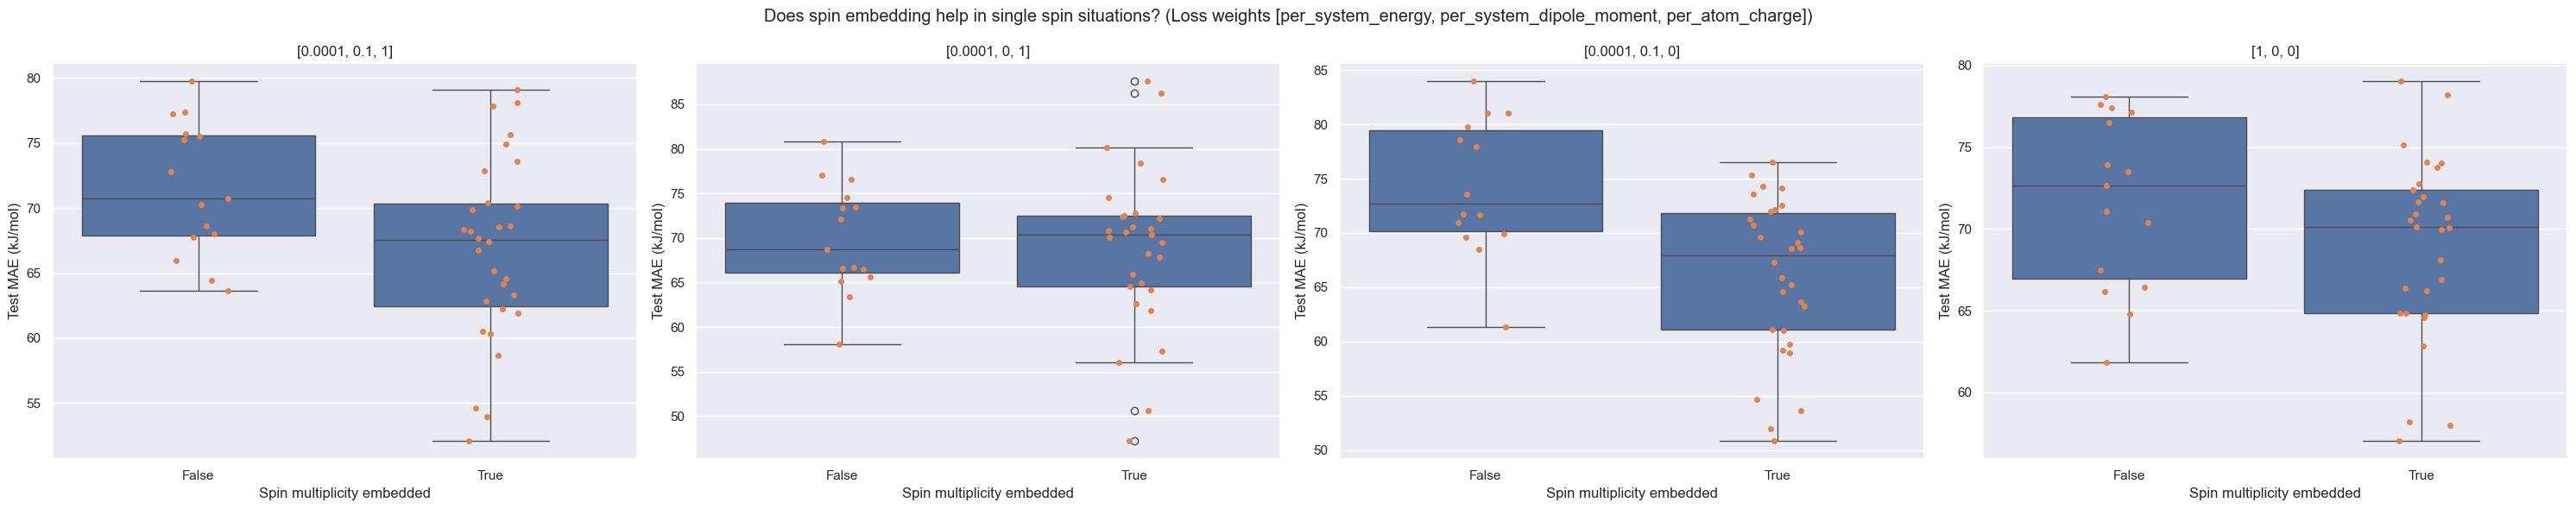

In [36]:
fig, axes = plt.subplots(1, 4, figsize=(30, 6))
fig.suptitle("Does spin embedding help in single spin situations? (Loss weights [per_system_energy, per_system_dipole_moment, per_atom_charge])")

options_version_select = [
    "full_dataset_sm1_v1.1",
    "full_dataset_sm3_v1.1",
    "full_dataset_sm5_v1.1",
]

options_loss_components = [
    [0.0001, 0.1, 1],
    [0.0001, 0, 1],
    [0.0001, 0.1, 0],
    [1, 0, 0],
]

for j in range(4):

    data = results_single_spin[
        # (results_single_spin["dataset_version"] == options_version_select[i]) &\
        (results_single_spin["per_system_energy"] == options_loss_components[j][0]) &\
        (results_single_spin["per_system_dipole_moment"] == options_loss_components[j][1]) &\
        (results_single_spin["per_atom_charge"] == options_loss_components[j][2])
    ].sort_values(by="dataset_version")
    
    sns.boxplot(
        ax=axes[j],
        data=data,
        x="spin_embedding",
        y="val/per_system_energy/mae",
        # hue="spin_embedding",
    )
    sns.stripplot(
        ax=axes[j],
        data=data, 
        x="spin_embedding", 
        y="val/per_system_energy/mae", 
        # hue="spin_embedding",
        # legend=False,
    )
    axes[j].set_xlabel("Spin multiplicity embedded")
    axes[j].set_ylabel("Test MAE (kJ/mol)")
    # axes[j].set_ylim(45, 80)
    axes[j].set_title(f"{options_loss_components[j]}")

fig.tight_layout()

### Full dataset comparison

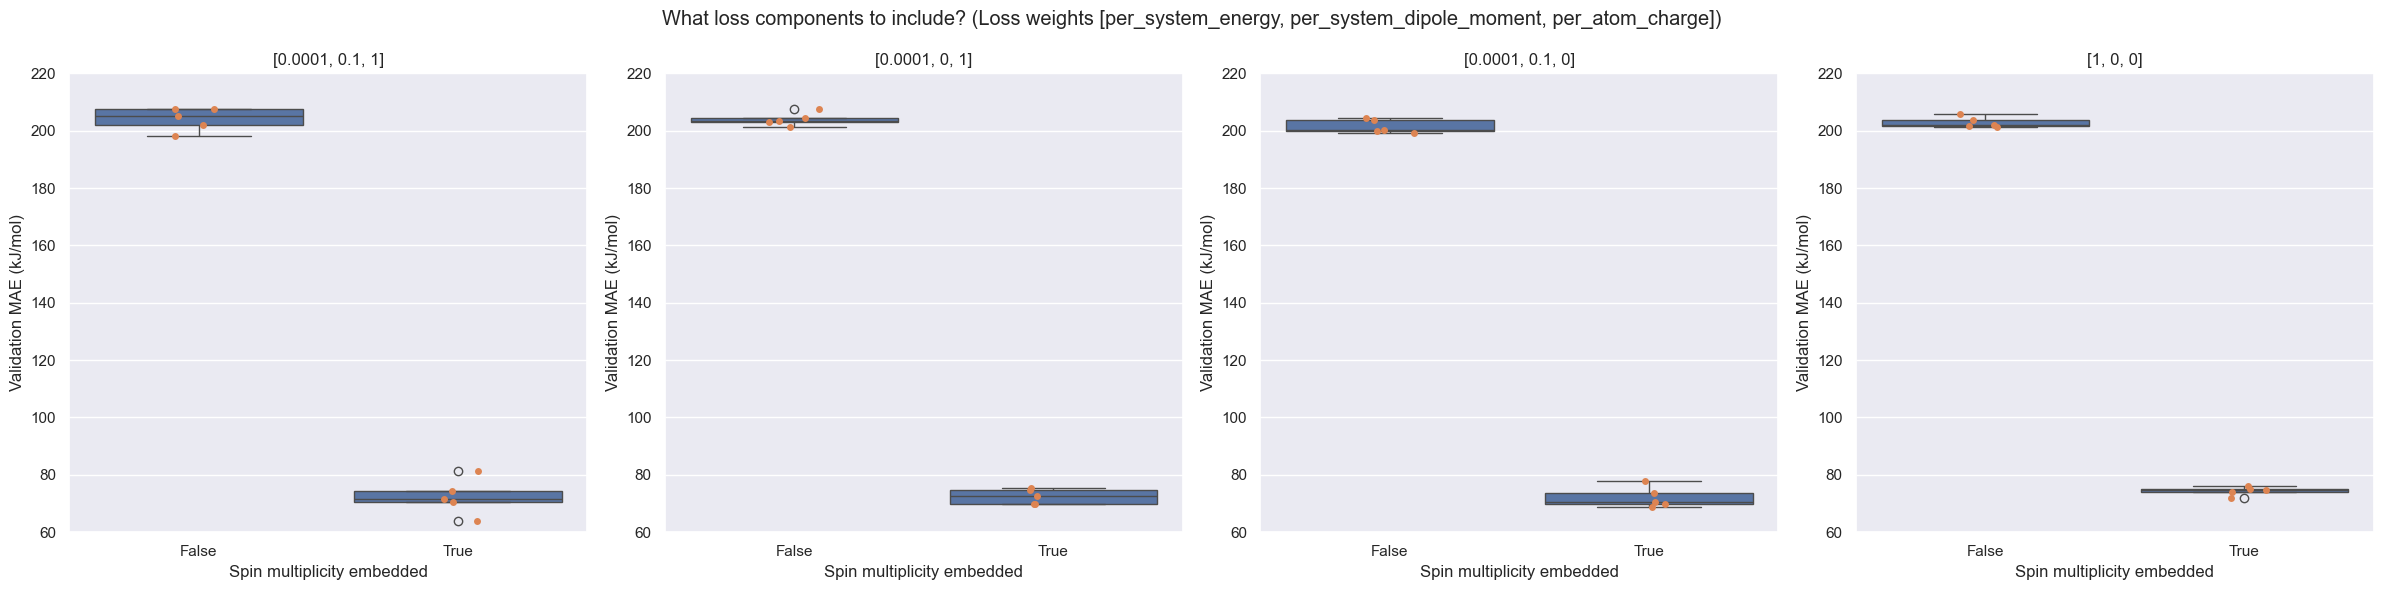

In [29]:
results_multi_spin = exp_results_df[exp_results_df["dataset_version"] == "full_dataset_v1.1"]

fig, axes = plt.subplots(1, 4, figsize=(24,6))
fig.suptitle("Does spin multiplicity embedding help? (Loss weights [per_system_energy, per_system_dipole_moment, per_atom_charge])")

options_loss_components = [
    [0.0001, 0.1, 1],
    [0.0001, 0, 1],
    [0.0001, 0.1, 0],
    [1, 0, 0],
]

for j in range(4):

    data = results_multi_spin[
        (results_multi_spin["per_system_energy"] == options_loss_components[j][0]) &\
        (results_multi_spin["per_system_dipole_moment"] == options_loss_components[j][1]) &\
        (results_multi_spin["per_atom_charge"] == options_loss_components[j][2])
    ].sort_values(by="dataset_version")
    
    sns.boxplot(
        ax=axes[j],
        data=data,
        x="spin_embedding",
        y="val/per_system_energy/mae",
    )
    sns.stripplot(
        ax=axes[j],
        data=data, 
        x="spin_embedding", 
        y="val/per_system_energy/mae", 
        legend=False,
    )
    axes[j].set_xlabel("Spin multiplicity embedded")
    axes[j].set_ylabel("Validation MAE (kJ/mol)")
    axes[j].set_ylim(60, 220)
    axes[j].set_title(f"{options_loss_components[j]}")

fig.tight_layout()

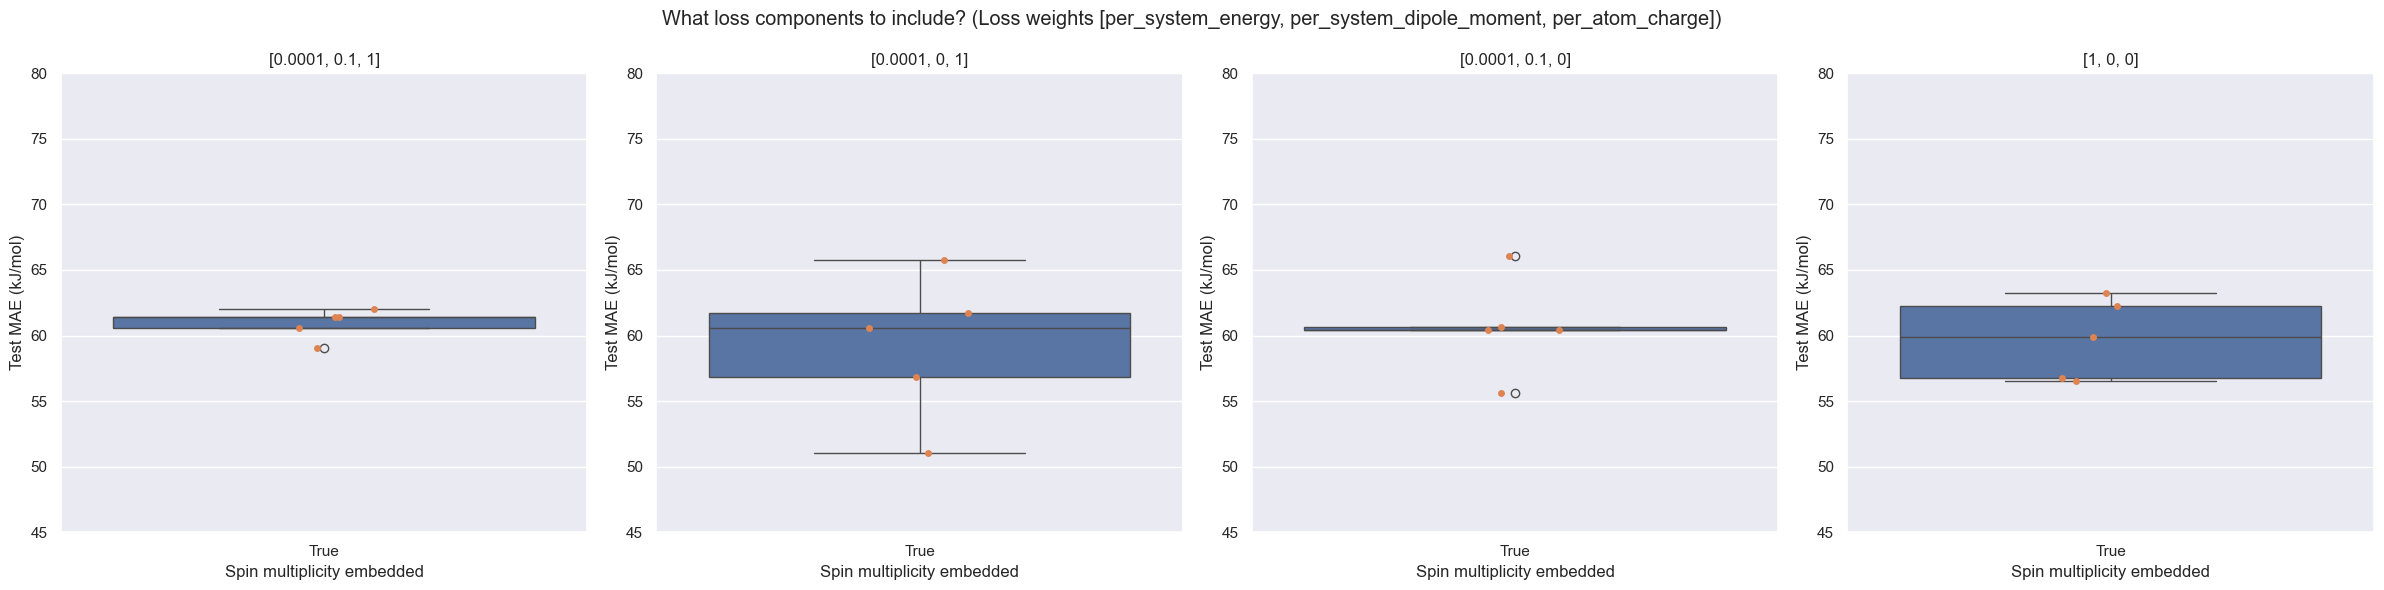

In [27]:
results_multi_spin = exp_results_df[exp_results_df["dataset_version"] == "full_dataset_v1.2"]

fig, axes = plt.subplots(1, 4, figsize=(24,6))
fig.suptitle("What loss components to include? (Loss weights [per_system_energy, per_system_dipole_moment, per_atom_charge])")

options_loss_components = [
    [0.0001, 0.1, 1],
    [0.0001, 0, 1],
    [0.0001, 0.1, 0],
    [1, 0, 0],
]

for j in range(4):

    data = results_multi_spin[
        (results_multi_spin["per_system_energy"] == options_loss_components[j][0]) &\
        (results_multi_spin["per_system_dipole_moment"] == options_loss_components[j][1]) &\
        (results_multi_spin["per_atom_charge"] == options_loss_components[j][2])
    ].sort_values(by="dataset_version")
    
    sns.boxplot(
        ax=axes[j],
        data=data,
        x="spin_embedding",
        y="test/per_system_energy/mae",
    )
    sns.stripplot(
        ax=axes[j],
        data=data, 
        x="spin_embedding", 
        y="test/per_system_energy/mae", 
        legend=False,
    )
    axes[j].set_xlabel("Spin multiplicity embedded")
    axes[j].set_ylabel("Test MAE (kJ/mol)")
    axes[j].set_ylim(45, 80)
    axes[j].set_title(f"{options_loss_components[j]}")

fig.tight_layout()

### How well are dipole moments and partial charges predicted?

In [21]:
exp_results_df["loss_components"] = exp_results_df["per_system_energy"]*1000000 + exp_results_df["per_system_dipole_moment"]*100 + exp_results_df["per_atom_charge"]
results_multi_spin = exp_results_df[exp_results_df["dataset_version"] == "full_dataset_v1.2"].sort_values("loss_components")
results_multi_spin

,name,test/per_system_energy/mae,test/per_system_energy/rmse,test/per_atom_charge/mae,test/per_atom_charge/rmse,test/per_system_dipole_moment/mae,test/per_system_dipole_moment/rmse,val/per_system_energy/mae,val/per_system_energy/rmse,val/per_system_dipole_moment/mae,val/per_atom_charge/mae,number_of_radial_basis_functions,number_of_vector_features,number_of_per_atom_features,per_system_energy,per_system_dipole_moment,per_atom_charge,dataset_version,spin_embedding,group,seed,loss_components
173,"full_dataset_v1.2_[0.0001, 0, 1]_(42)",65.76081,103.982433,0.034768,<NA>,0.149037,<NA>,67.073799,111.661140,0.146359,0.034818,64,8,128,0.0001,0.0,1.0,full_dataset_v1.2,True,exp08_3,42,101.0
234,"full_dataset_v1.2_[0.0001, 0, 1]_(46)",56.867731,102.838047,0.023105,<NA>,0.138562,<NA>,46.471733,85.297318,0.136738,0.024444,64,8,128,0.0001,0.0,1.0,full_dataset_v1.2,True,exp08_3,46,101.0
186,"full_dataset_v1.2_[0.0001, 0, 1]_(43)",60.598629,107.015846,0.029115,<NA>,0.142581,<NA>,50.529491,92.023438,0.145163,0.029573,64,8,128,0.0001,0.0,1.0,full_dataset_v1.2,True,exp08_3,43,101.0
221,"full_dataset_v1.2_[0.0001, 0, 1]_(45)",51.070604,86.14447,0.035162,<NA>,0.144881,<NA>,47.071945,86.559341,0.147555,0.035212,64,8,128,0.0001,0.0,1.0,full_dataset_v1.2,True,exp08_3,45,101.0
201,"full_dataset_v1.2_[0.0001, 0, 1]_(44)",61.747408,94.138082,0.028496,<NA>,0.144816,<NA>,63.711807,99.518059,0.149377,0.029265,64,8,128,0.0001,0.0,1.0,full_dataset_v1.2,True,exp08_3,44,101.0
174,"full_dataset_v1.2_[0.0001, 0.1, 0]_(42)",66.042306,101.189025,0.230577,<NA>,0.153168,<NA>,65.617981,108.594543,0.156215,0.230773,64,8,128,0.0001,0.1,0.0,full_dataset_v1.2,True,exp08_3,42,110.0
187,"full_dataset_v1.2_[0.0001, 0.1, 0]_(43)",60.400674,106.41322,0.170226,<NA>,0.137228,<NA>,50.162586,95.537132,0.139438,0.171702,64,8,128,0.0001,0.1,0.0,full_dataset_v1.2,True,exp08_3,43,110.0
235,"full_dataset_v1.2_[0.0001, 0.1, 0]_(46)",60.647305,95.632348,0.13954,<NA>,0.139801,<NA>,62.044998,102.925896,0.137734,0.142442,64,8,128,0.0001,0.1,0.0,full_dataset_v1.2,True,exp08_3,46,110.0
203,"full_dataset_v1.2_[0.0001, 0.1, 0]_(44)",55.584137,96.890449,0.188244,<NA>,0.13767,<NA>,48.061447,86.444557,0.140324,0.189907,64,8,128,0.0001,0.1,0.0,full_dataset_v1.2,True,exp08_3,44,110.0
219,"full_dataset_v1.2_[0.0001, 0.1, 0]_(45)",60.429945,96.451665,0.156155,<NA>,0.140625,<NA>,61.649239,104.188202,0.141049,0.157021,64,8,128,0.0001,0.1,0.0,full_dataset_v1.2,True,exp08_3,45,110.0


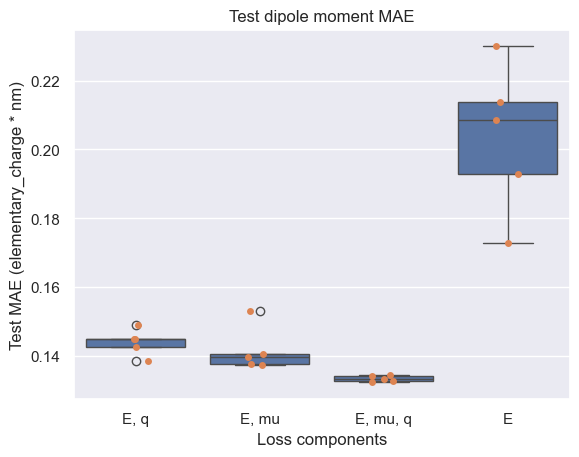

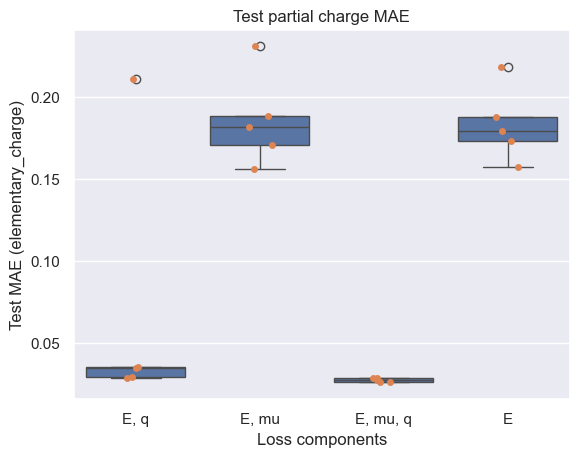

In [13]:
# dipole moment
ax = sns.boxplot(
    data=results_multi_spin,
    x="loss_components",
    y="test/per_system_dipole_moment/mae",
)
sns.stripplot(
    ax=ax,
    data=results_multi_spin, 
    x="loss_components", 
    y="test/per_system_dipole_moment/mae", 
    legend=False,
)
ax.set_xlabel("Loss components")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(
    [
        "E, q",
        "E, mu",
        "E, mu, q",
        "E"
    ]
)
ax.set_ylabel("Test MAE (elementary_charge * nm)")
ax.set_title(f"Test dipole moment MAE")

# fig.tight_layout()
plt.show()

# # partial charge
ax = sns.boxplot(
    data=results_multi_spin,
    x="loss_components",
    y="test/per_atom_charge/mae",
)
sns.stripplot(
    ax=ax,
    data=results_multi_spin, 
    x="loss_components", 
    y="test/per_atom_charge/mae", 
    legend=False,
)
ax.set_xlabel("Loss components")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(
    [
        "E, q",
        "E, mu",
        "E, mu, q",
        "E"
    ]
)
ax.set_ylabel("Test MAE (elementary_charge)")
ax.set_title(f"Test partial charge MAE")

# fig.tight_layout()
plt.show()